In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
sp_500_companies = pd.read_csv('/content/drive/My Drive/sp500_companies.csv')
sp_500_index = pd.read_csv('/content/drive/My Drive/sp500_index.csv')
sp_500_stocks = pd.read_csv('/content/drive/My Drive/sp500_stocks.csv')


In [7]:
files={"S&P Companies Data": sp_500_companies,
       "S&P Index Data": sp_500_index,
       "S&P Stocks Data": sp_500_stocks}

In [8]:
def information(df):
  print(f"\n--------Information About {df}--------\n")
  # DF Columns
  print(f"Column Data \n {files[df].info()}")

  # DF Sample
  print("\n")
  print(f"------Sample Data------\n{files[df].head(2)}")

  # DF Null Values
  df_null=round(files[df].isna().sum()/files[df].isna().count()*100,2).sort_values(ascending=False)
  print("\n")
  print(f"Null Values are \n{df_null}")

  # Dropping Null Values
  files[df].dropna(inplace=True)

In [9]:
# DF Information
for key in files:
  information(key)


--------Information About S&P Companies Data--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             503 non-null    object 
 1   Symbol               503 non-null    object 
 2   Shortname            503 non-null    object 
 3   Longname             503 non-null    object 
 4   Sector               503 non-null    object 
 5   Industry             503 non-null    object 
 6   Currentprice         503 non-null    float64
 7   Marketcap            503 non-null    int64  
 8   Ebitda               474 non-null    float64
 9   Revenuegrowth        501 non-null    float64
 10  City                 503 non-null    object 
 11  State                483 non-null    object 
 12  Country              503 non-null    object 
 13  Fulltimeemployees    498 non-null    float64
 14  Longbusinesssummary  503 non-null  

In [10]:
# Changing the Date Columns from Object Datatype to Date
def change_format(file):
  file['Date'] = pd.to_datetime(file['Date'], format='%Y-%m-%d')

change_format(sp_500_index)
change_format(sp_500_stocks)

In [11]:
sp_500_companies['Marketcap']=round(sp_500_companies['Marketcap']/1000000000,2)
sp_500_companies['Ebita']=round(sp_500_companies['Ebitda']/1000000000,2)
sp_500_companies['Weight']=round(sp_500_companies['Weight']*100,2)

**Breakdown of Sectors in S&P 500**

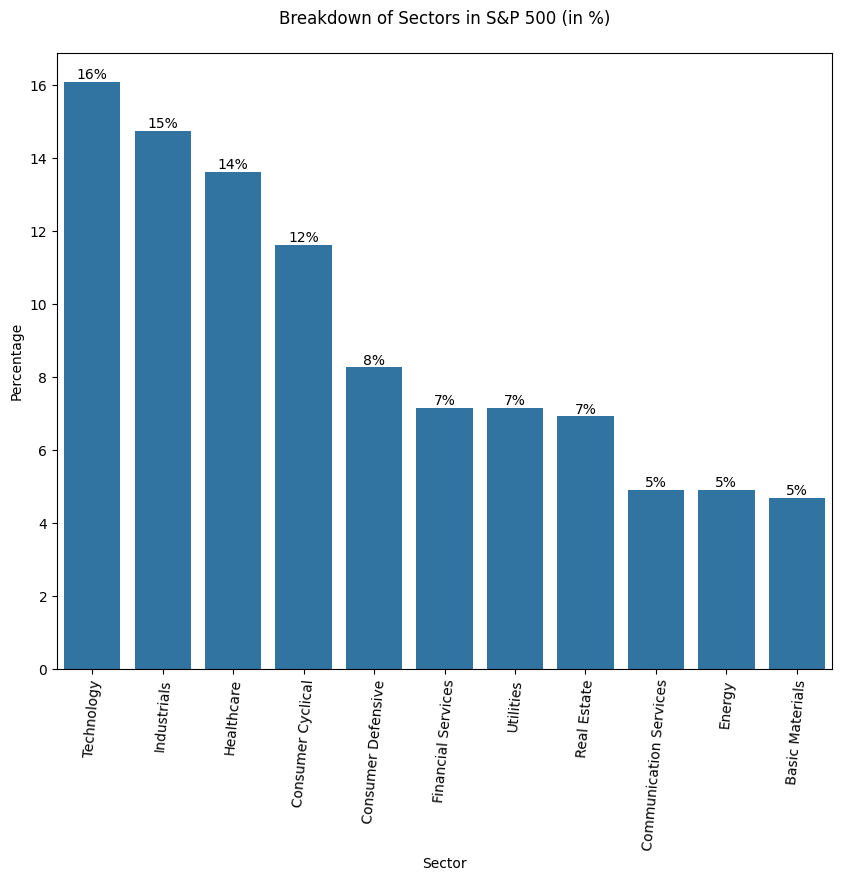

In [12]:
plt.subplots(figsize=(10,8))
sector = sp_500_companies.groupby(by='Sector')['Symbol'].apply(lambda x:round(x.count()/len(sp_500_companies)*100,2)).reset_index().sort_values(by='Symbol', ascending=False)
ax = sns.barplot(data=sector, x='Sector', y='Symbol')
ax.bar_label(ax.containers[0],fmt='%.0f%%')
plt.xticks(rotation=85)
plt.title("Breakdown of Sectors in S&P 500 (in %)\n")
ax.set_ylabel("Percentage")
plt.show()

**Top 10 Companies by Marketcap and Weight**

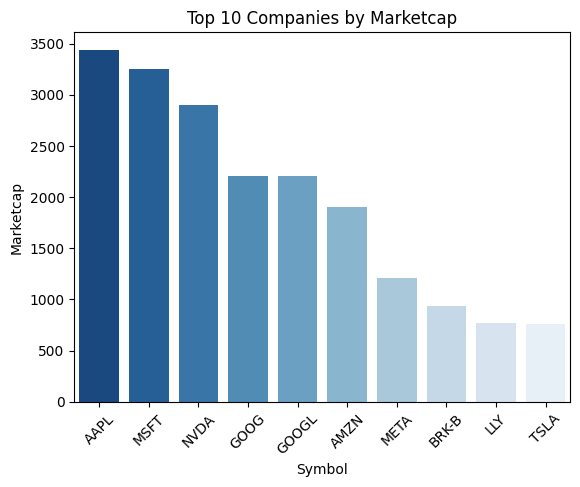

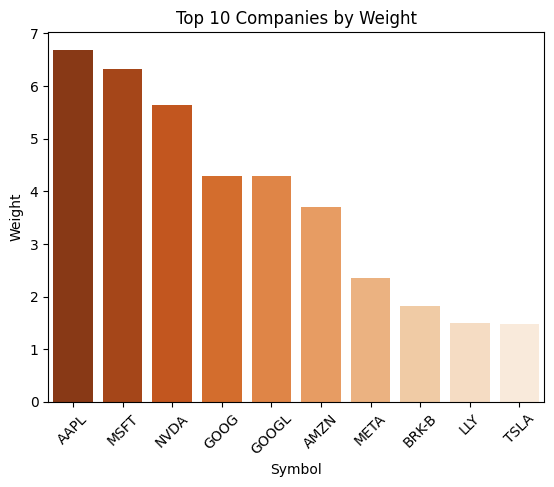

In [13]:
estimators=['Marketcap', 'Weight']
color={'Marketcap':'Blues_r', 'Weight':'Oranges_r'}
for est in estimators:
  sns.barplot(data=sp_500_companies.sort_values(by=est, ascending=False).head(10), y=est, x="Symbol", palette=color[est])
  plt.xticks(rotation=45)
  plt.title("Top 10 Companies by {}".format(est))
  plt.show()

**Information on Top Companies**

In [14]:
top_company_mkcp = sp_500_companies[['Symbol', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Fulltimeemployees', 'Weight']].sort_values(by='Marketcap', ascending=False).head(10)
top_company_mkcp

,Symbol,Currentprice,Marketcap,Ebitda,Revenuegrowth,Fulltimeemployees,Weight
0,AAPL,224.31,3439.59,1.296290e+11,-0.043,150000.0,6.69
1,MSFT,437.11,3248.74,1.259820e+11,0.170,221000.0,6.32
2,NVDA,117.93,2900.88,4.927500e+10,2.621,29600.0,5.64
3,GOOG,179.39,2205.24,1.097230e+11,0.154,180895.0,4.29
4,GOOGL,177.66,2205.24,1.097230e+11,0.154,180895.0,4.29
5,AMZN,183.13,1905.76,9.660900e+10,0.125,1525000.0,3.71
6,META,476.79,1209.39,6.844700e+10,0.273,69329.0,2.35
7,BRK-B,434.47,936.56,1.070460e+11,0.052,396500.0,1.82
8,LLY,857.47,772.07,1.337370e+10,0.260,43000.0,1.50
9,TSLA,239.20,762.86,1.226500e+10,-0.087,140473.0,1.48


**Top Company Statistics**

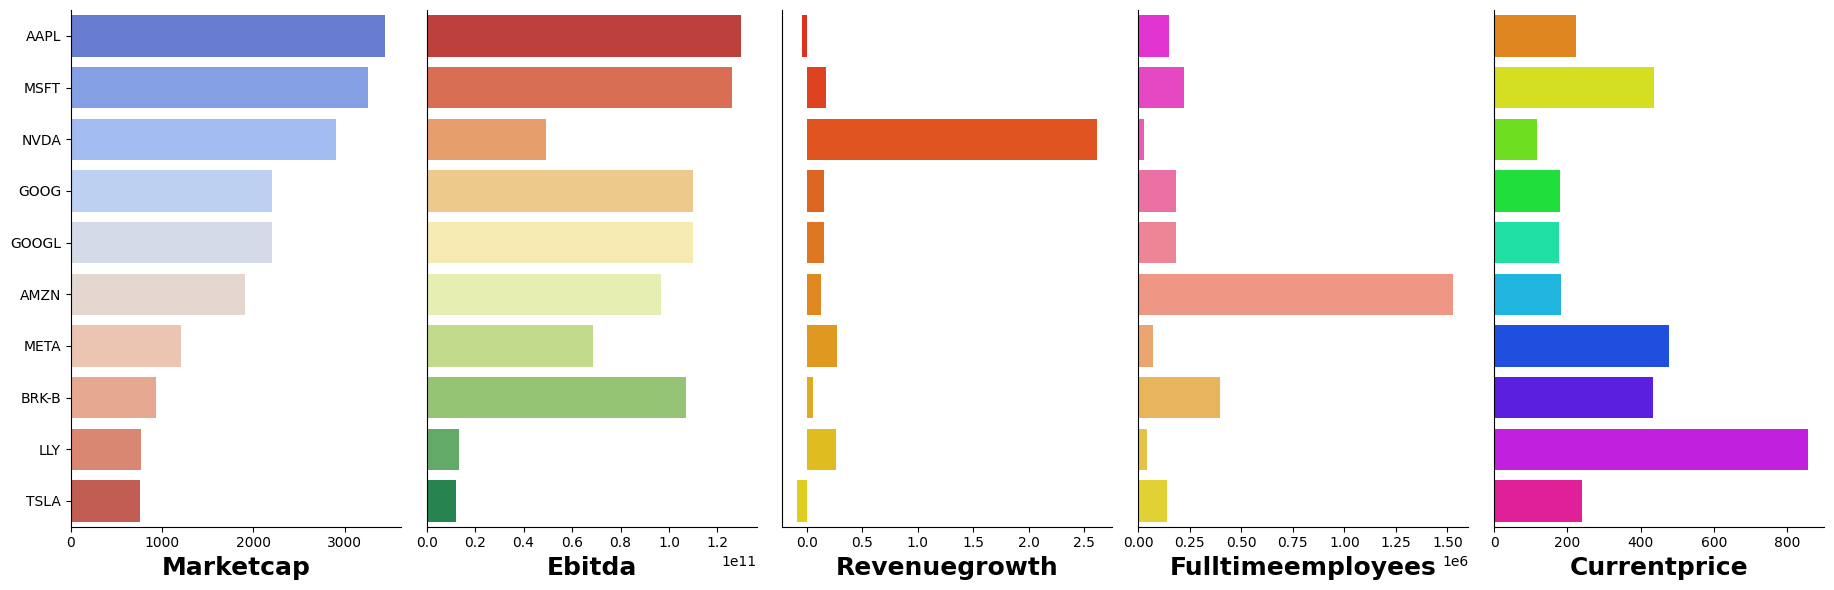

In [15]:
fig = plt.figure(figsize=(22, 6), num=None)
x_stats=["Marketcap", "Ebitda", "Revenuegrowth", "Fulltimeemployees", "Currentprice"]
palette={"Marketcap":"coolwarm", "Ebitda":"RdYlGn", "Revenuegrowth":"autumn", "Fulltimeemployees":"spring", "Currentprice":"hsv"}

for i in range(len(x_stats)):
  ax=plt.subplot(1, 6, i+1)
  ax=sns.barplot(x=x_stats[i], y="Symbol", data=top_company_mkcp, palette=palette[x_stats[i]])
  ax.set_xlabel(x_stats[i], weight='bold',fontsize=18)
  ax.set_ylabel('')
  if i != 0:
    ax.set_yticks([])
sns.despine()
plt.tight_layout()

**Count of Stocks from Each Country**

In [16]:
sp_500_companies["Country"].unique()

array(['United States', 'Canada'], dtype=object)

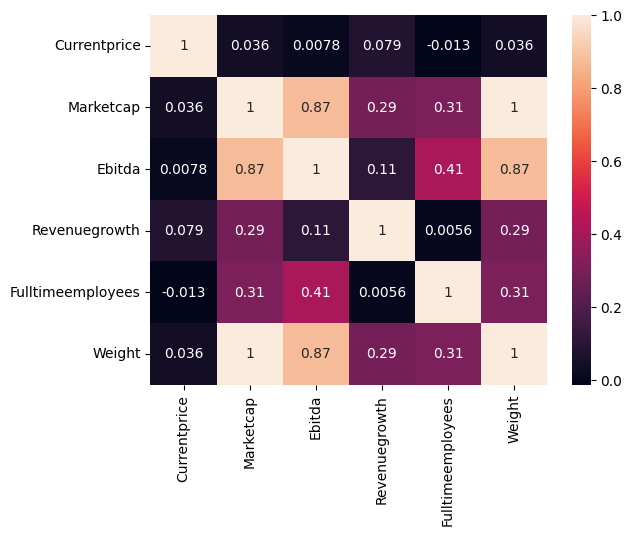

In [17]:
# Heatmap
sns.heatmap(sp_500_companies[['Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Fulltimeemployees', 'Weight']].corr(), annot=True)
plt.show()

In [18]:
def sp_top_companies(sec,ind, fig, ax,i):
  j=0
  for indus in ind['Industry']:
    top_5_comp=sp_500_companies[sp_500_companies['Industry']==indus].groupby('Symbol').agg({'Currentprice':'mean'}).reset_index().sort_values(by='Currentprice', ascending=False).head(5)
    ax[i,j].bar(top_5_comp['Symbol'],top_5_comp['Currentprice'])
    ax[i,j].set_title(indus, fontsize=22, weight='bold')
    ax[i,j].tick_params(size=30)
    j=j+1

**Top 3 Industries in Each Sector**

In [19]:
def sp_top_ind(sec, fig, ax, i):
  top_3_industries=sp_500_companies[sp_500_companies['Sector']==sec].groupby('Industry').agg({'Currentprice':'mean'}).reset_index().sort_values(by='Currentprice', ascending=False).head(3)
  sp_top_companies(sec, top_3_industries, fig, ax, i)


In [20]:
# Top 5 Sectors
sp_top_sector = sp_500_companies.groupby('Sector').agg({'Currentprice':'mean'}).reset_index().sort_values(by='Currentprice', ascending=False).head(5)
sp_top_sector

,Sector,Currentprice
2,Consumer Cyclical,453.711058
9,Technology,260.745000
6,Healthcare,246.608361
7,Industrials,223.308485
5,Financial Services,211.381875


Top 5 Companies
   
     in
      
      Top 3 Sectors

          of

            Top 5 Industries

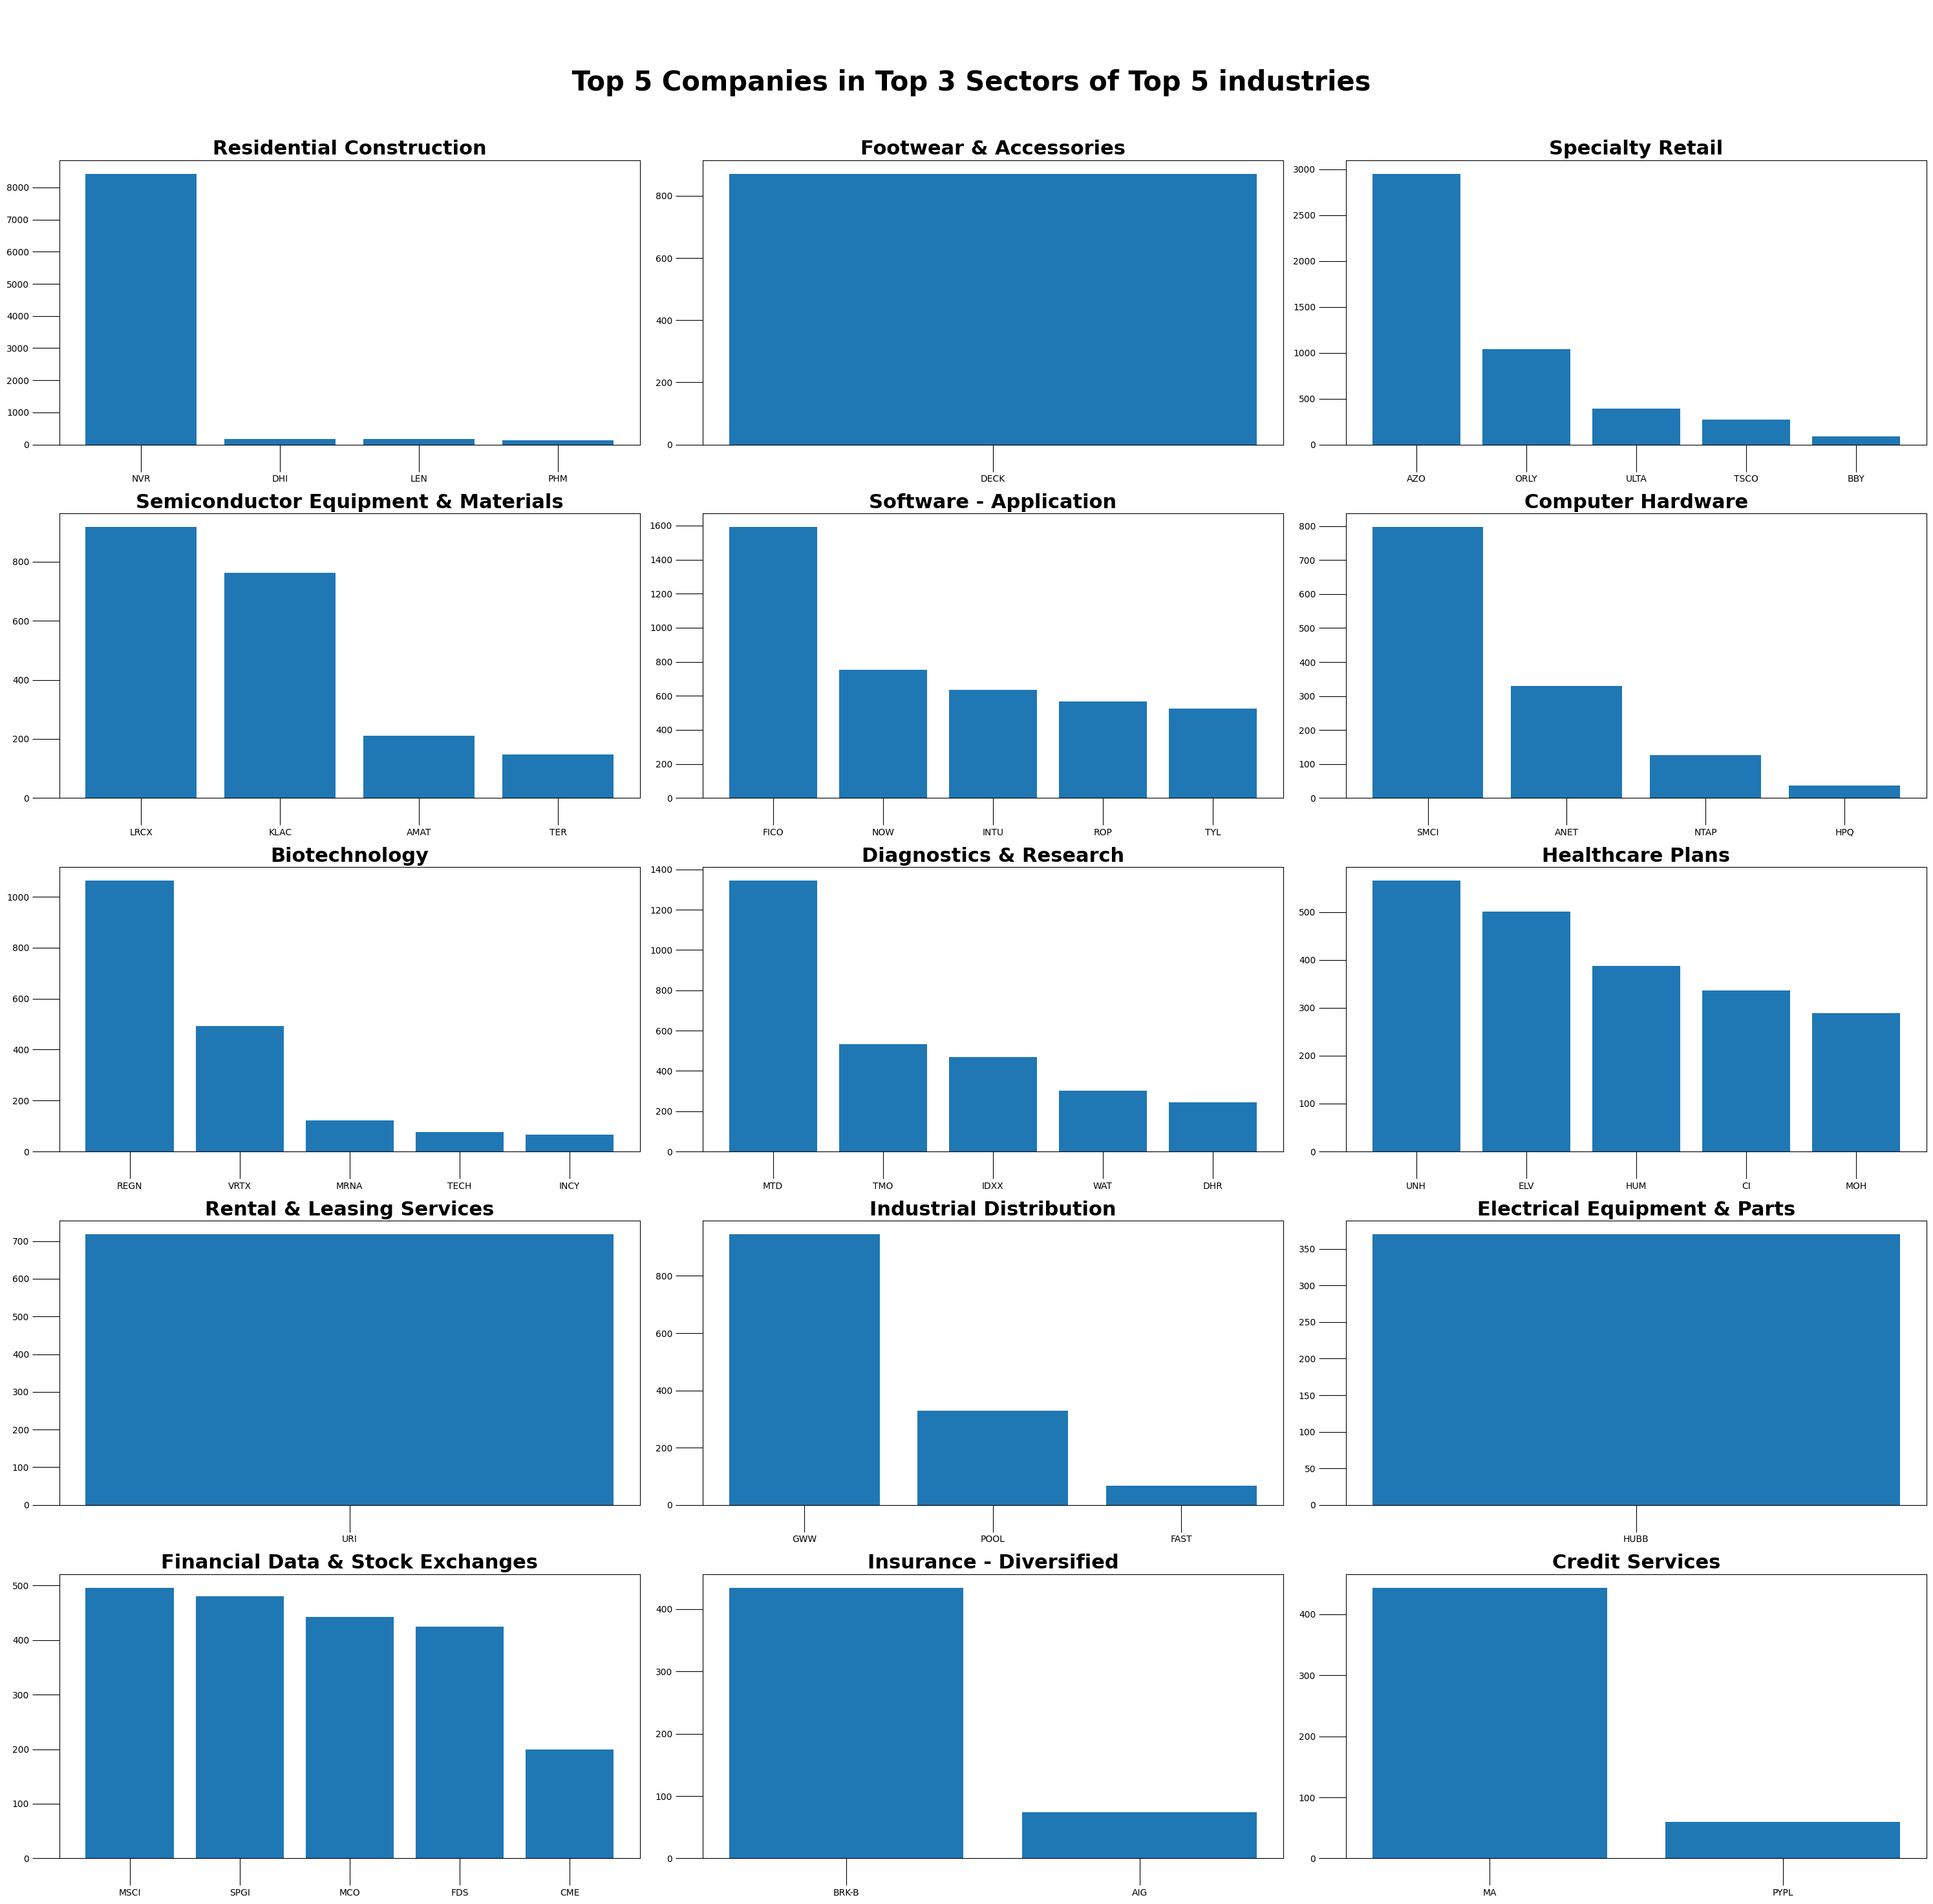

In [21]:
# top 5 Sector
sp_top_sector=sp_500_companies.groupby('Sector').agg({'Currentprice':'mean'}).reset_index().sort_values(by='Currentprice',ascending=False).head(5)
fig, ax= plt.subplots(5,3,figsize=(30,30))
fig.suptitle('\n\n Top 5 Companies in Top 3 Sectors of Top 5 industries\n\n', fontsize=30, weight='bold')
i=0
for sec in sp_top_sector['Sector']:
    sp_top_ind(sec, fig,ax,i)
    i=i+1
fig.tight_layout()

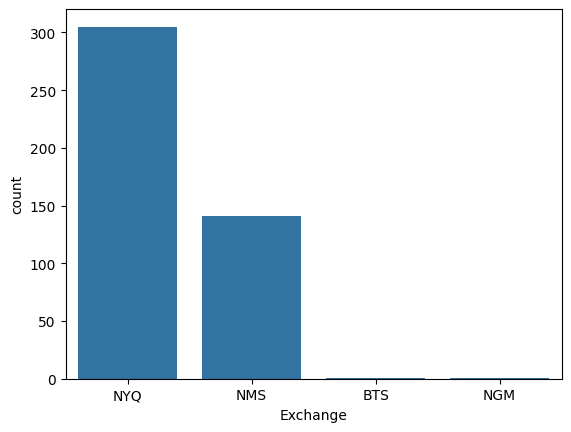

In [22]:
# Number of companies for each exchange
sns.countplot(data=sp_500_companies, x="Exchange", order=sp_500_companies['Exchange'].value_counts().index)
plt.show()



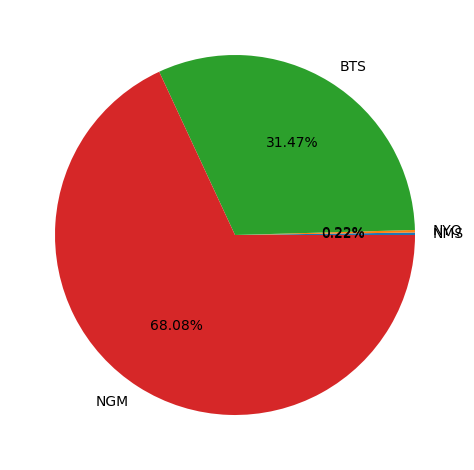

In [23]:
plt.pie(sp_500_companies.groupby(['Exchange'])['Symbol'].count(), labels=sp_500_companies['Exchange'].unique(), autopct='%.2f%%')
plt.tight_layout()
plt.show()

**S&P 500 Index Performance**


In [24]:

import datetime
from datetime import date

# S&P Index Performance Over Last Year

today=datetime.date.today()
year=today.year
month=today.month

sp_500_index['year']=sp_500_index['Date'].dt.year
sp_500_index['month']=sp_500_index['Date'].dt.month

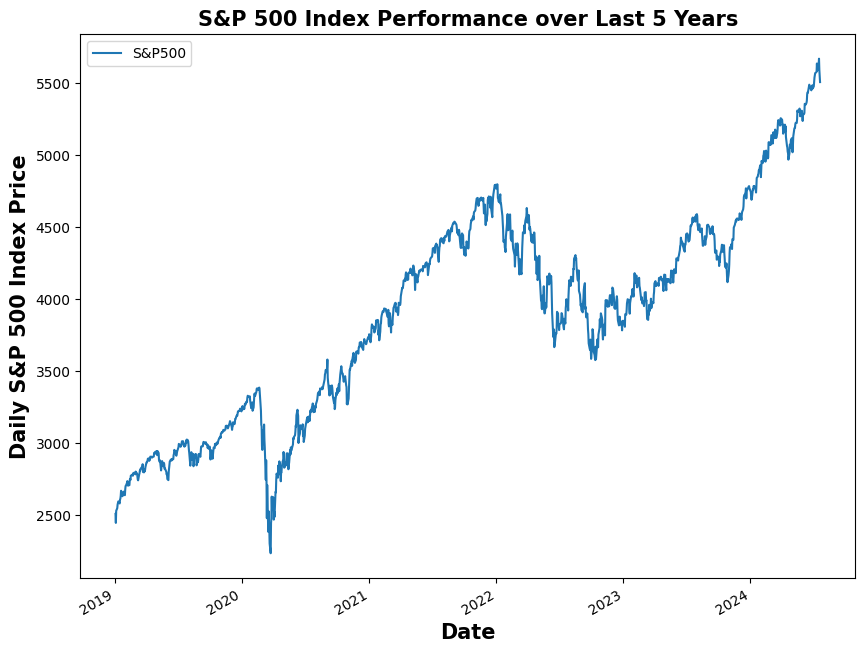

In [25]:
# S&P Index Performance for Last 5 Years
ax = sp_500_index[sp_500_index['year']>=year-5][['S&P500', 'Date']].set_index('Date').plot(figsize=(10, 8))
plt.title("S&P 500 Index Performance over Last 5 Years", weight='bold', fontsize=15)
ax.set_xlabel("Date", weight='bold', fontsize=15)
ax.set_ylabel("Daily S&P 500 Index Price", weight='bold', fontsize=15)
plt.show()

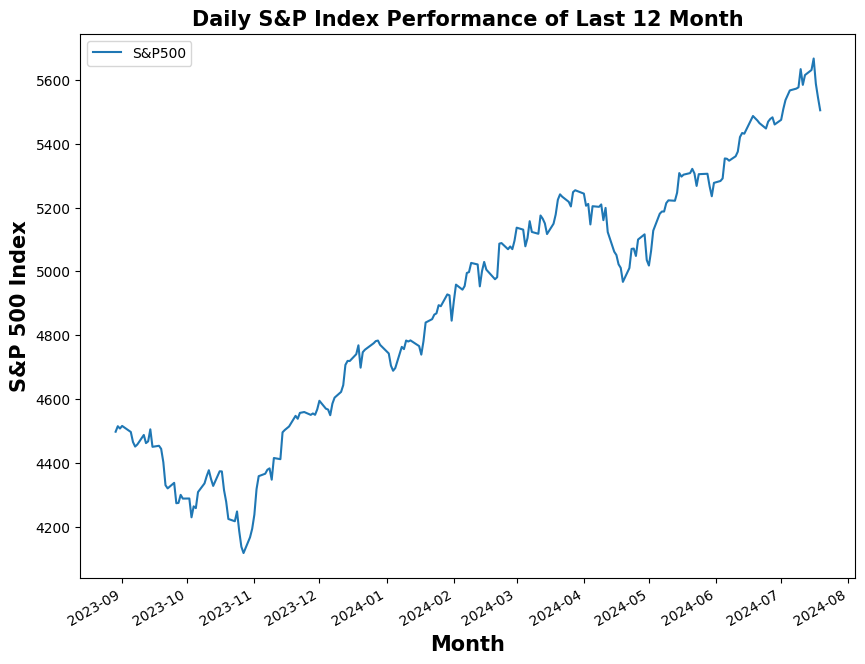

In [26]:
# Daily S&P Index Performance of Last 12 Month
from dateutil.relativedelta import relativedelta
past_date=today - relativedelta(months=12)
ax=sp_500_index[pd.to_datetime(sp_500_index['Date']).dt.date>past_date][["Date",'S&P500']].set_index("Date").plot(figsize=(10,8))
plt.title("Daily S&P Index Performance of Last 12 Month", weight='bold', fontsize=15)
ax.set_xlabel("Month", weight='bold', fontsize=15)
ax.set_ylabel("S&P 500 Index",weight='bold', fontsize=15)
plt.show()

In [27]:
# Current Market Cap of S&P 500 Index

print(f"Total Market Cap of S&P 500 Index is ${round(sp_500_companies['Marketcap'].sum()/1000,3)} trillion dollars")

Total Market Cap of S&P 500 Index is $46.248 trillion dollars


In [28]:
# Biggest and lowest movers as of last day
last_day_stock_data=sp_500_stocks[sp_500_stocks["Date"]==sp_500_stocks["Date"].max()]
last_day_stock_data['per_change']=round((last_day_stock_data['Close']-last_day_stock_data['Open'])/last_day_stock_data['Open']*100,2)
last_day_stock_data['big_movers']=round((last_day_stock_data['High']-last_day_stock_data['Low'])/last_day_stock_data['Low']*100,2)

print(last_day_stock_data.sort_values(by="per_change", ascending=False).head(5))
print(last_day_stock_data.sort_values(by='big_movers', ascending=False).head(5))

              Date Symbol   Adj Close       Close        High         Low  \
1559159 2024-07-19   SBUX   79.269997   79.269997   79.379997   74.190002   
1694579 2024-07-19    UAL   47.930000   47.930000   48.310001   44.950001   
494099  2024-07-19   CRWD  304.959991  304.959991  316.750000  290.100006   
640499  2024-07-19    EQT   35.880001   35.880001   35.919998   34.950001   
1573799 2024-07-19    SYK  340.950012  340.950012  341.390015  331.970001   

               Open      Volume  per_change  big_movers  
1559159   74.660004  32934000.0        6.17        7.00  
1694579   45.900002   9593700.0        4.42        7.47  
494099   294.510010  41995900.0        3.55        9.19  
640499    35.040001  66338900.0        2.40        2.78  
1573799  333.369995   2421800.0        2.27        2.84  
              Date Symbol   Adj Close       Close        High         Low  \
494099  2024-07-19   CRWD  304.959991  304.959991  316.750000  290.100006   
1756799 2024-07-19    WRB   51.5400

**Top 100 most traded stocks in last 5 years & Sectors**

Text(0, 0.5, '% of Companies')

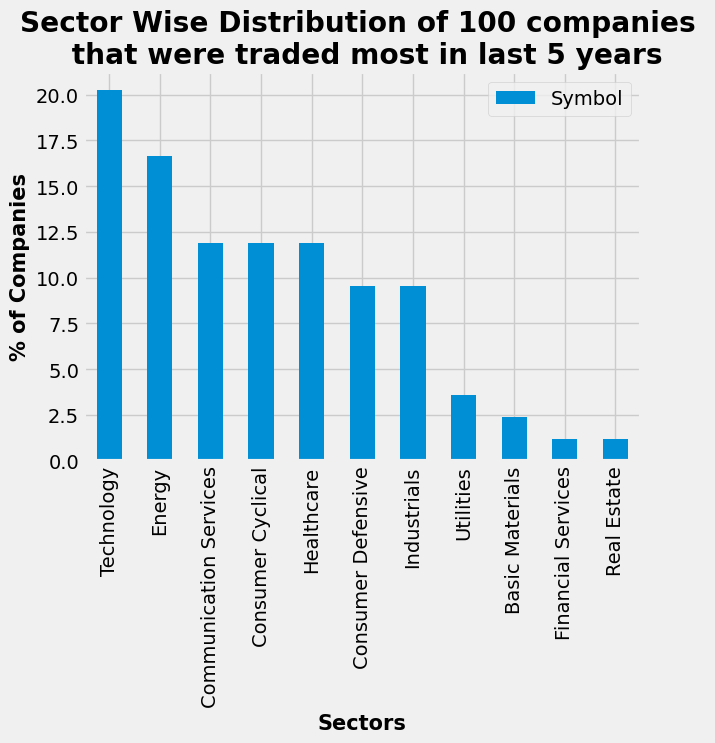

In [29]:
sp_top_stocks=sp_500_stocks[pd.to_datetime(sp_500_stocks['Date']).dt.year>=year-5].groupby('Symbol').agg({'Volume':'mean'}).round()
sp_top_stocks=sp_top_stocks.sort_values(['Volume'], ascending=False).head(100).apply(lambda x:x/1000000).round(2).rename(columns={'Volume':'Volume (in $M)'})
sp_top_trded=pd.merge(sp_top_stocks,sp_500_companies, how='left', on=['Symbol'])
plt.style.use('fivethirtyeight')
sp_top_trded[['Symbol','Sector']].groupby(by='Sector').count().apply(lambda x:round(x/sum(x)*100,2)).sort_values(by='Symbol', ascending=False).plot.bar()
plt.title("Sector Wise Distribution of 100 companies \n that were traded most in last 5 years", weight='bold')
plt.xlabel('Sectors', weight='bold', fontsize=15)
plt.ylabel('% of Companies', weight='bold', fontsize=15)

In [30]:
sp_500_stocks[pd.to_datetime(sp_500_stocks['Date']).dt.year>=year-5].head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
2264,2019-01-02,MMM,127.544327,159.657196,159.690628,156.103683,157.040131,2960339.0
2265,2019-01-03,MMM,122.741783,153.645493,157.424744,152.918060,157.424744,4016407.0
2266,2019-01-04,MMM,127.791412,159.966553,160.518402,155.543472,156.145493,3582140.0
2267,2019-01-07,MMM,127.497536,159.598663,160.785950,157.742477,160.000000,2585991.0
2268,2019-01-08,MMM,128.031921,160.267563,162.299332,158.511703,161.371231,2965841.0


In [31]:
sp_500_stocks['year']=sp_500_stocks['Date'].dt.year
sp_stock_data=pd.merge(sp_500_stocks, sp_500_companies[['Symbol','Sector','Industry']], how='left', on=['Symbol'])



sp_500_stocks_agg=sp_500_stocks.groupby(['Symbol','year'])['Volume'].sum().apply(lambda x: x/1000000).round(2).reset_index()
sp_stock_data=pd.merge(sp_500_stocks_agg, sp_500_companies[['Symbol','Sector']], how='left', on=['Symbol'])
top_stock_history=sp_stock_data.groupby(['Sector','year'])['Volume'].sum().reset_index().round(2)

sp_stock_data.head()

,Symbol,year,Volume,Sector
0,A,2010,1241.72,Healthcare
1,A,2011,1527.25,Healthcare
2,A,2012,1149.04,Healthcare
3,A,2013,1073.41,Healthcare
4,A,2014,758.89,Healthcare


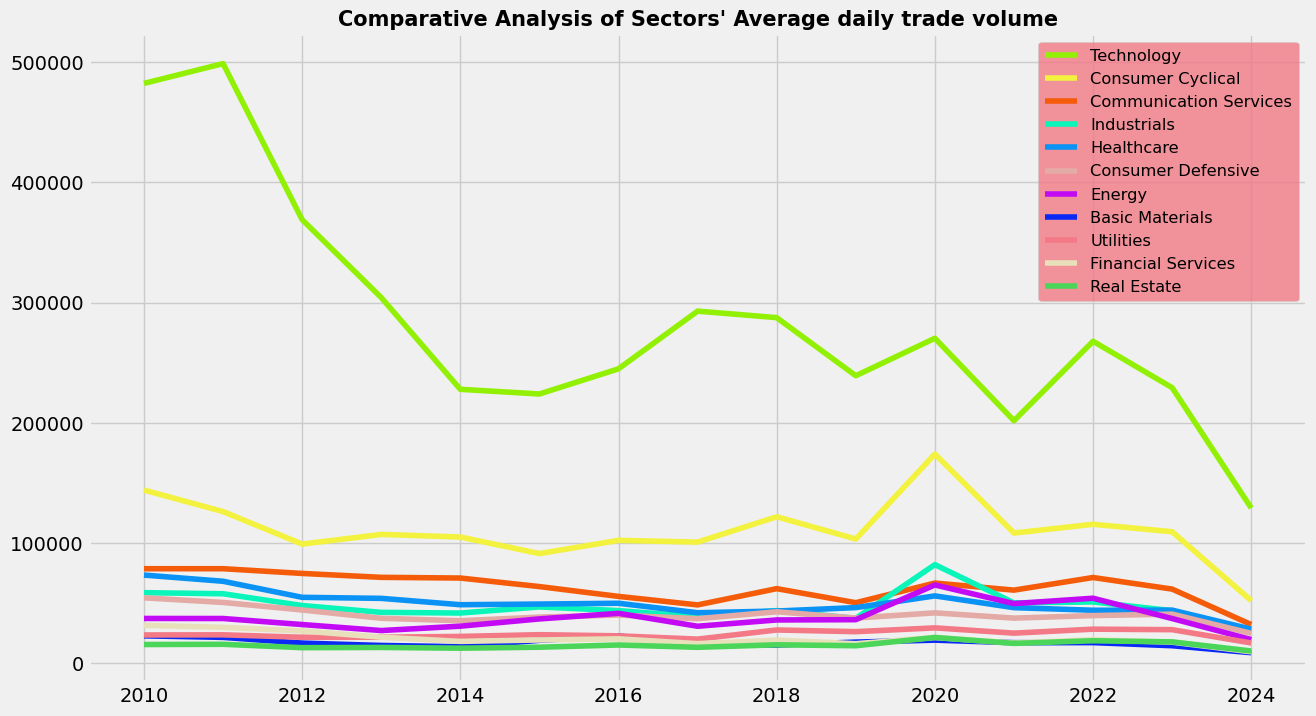

In [32]:
fig, ax=plt.subplots(figsize=(14,8))
color={'Consumer Cyclical':'#f2f23f','Technology':'#92f005','Communication Services':'#f55c0a','Industrials':'#0af5ba','Healthcare':'#0a93f5','Basic Materials':'#0a29f5','Energy':'#c20af5','Consumer Defensive':'#e3aaa6','Financial Services':'#e8e0ba','Utilities':'#f27985','Real Estate':'#4bd659', 'nan':'#4bd659'}
for sec in sp_top_trded[~sp_top_trded['Sector'].isnull()]['Sector'].unique():
    top_stock_history_temp=top_stock_history[top_stock_history['Sector']==sec]
    ax.plot(top_stock_history_temp['year'], top_stock_history_temp['Volume'], label=sec, color=color[sec])

ax.set_title("Comparative Analysis of Sectors' Average daily trade volume", weight='bold', fontsize=15)
ax.legend(facecolor='#f27985', fontsize="small")
plt.show()


In [33]:
top_stock_history_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 120 to 134
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sector  15 non-null     object 
 1   year    15 non-null     int32  
 2   Volume  15 non-null     float64
dtypes: float64(1), int32(1), object(1)
memory usage: 420.0+ bytes


In [34]:
top_stock_history.pivot(index='Sector',columns="year", values="Volume")
top_stock_history['Sector'].unique()

array(['Basic Materials', 'Communication Services', 'Consumer Cyclical',
       'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare',
       'Industrials', 'Real Estate', 'Technology', 'Utilities'],
      dtype=object)

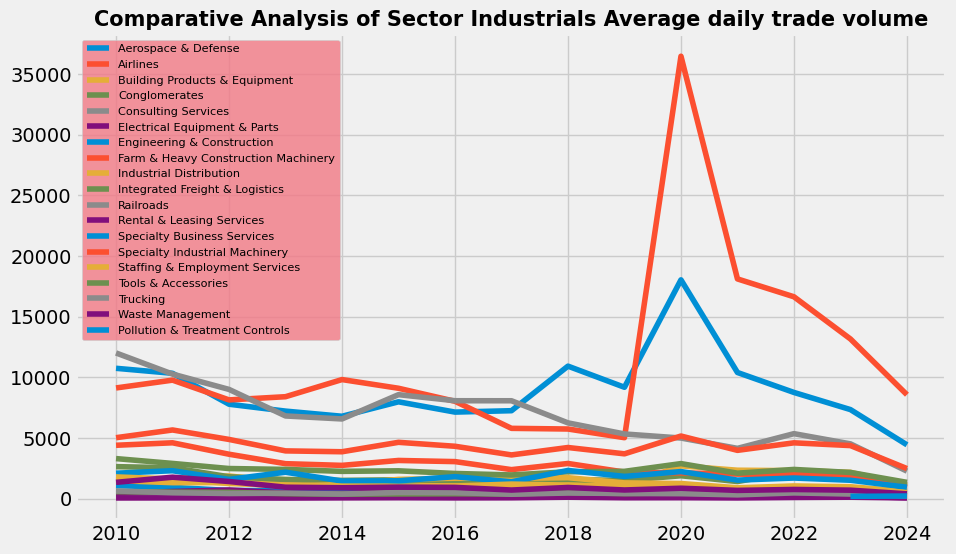

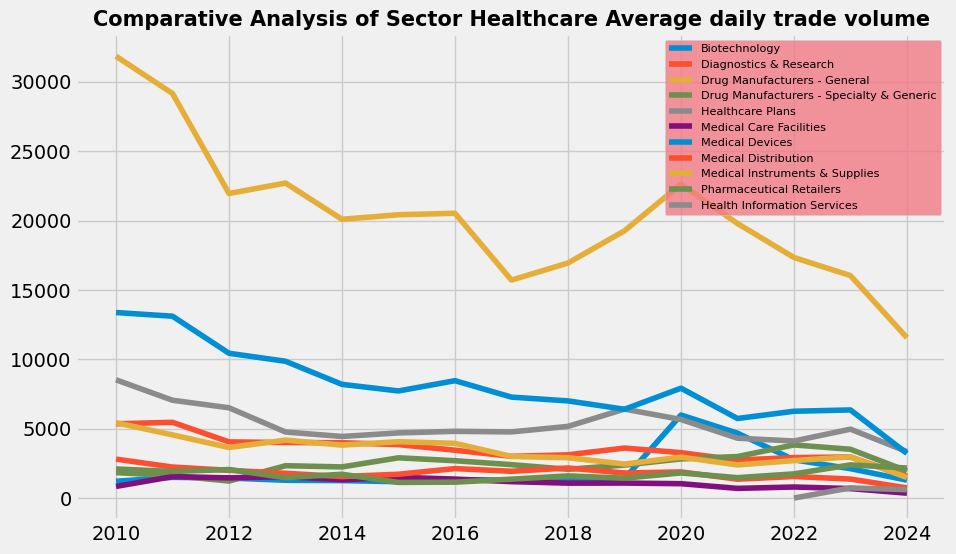

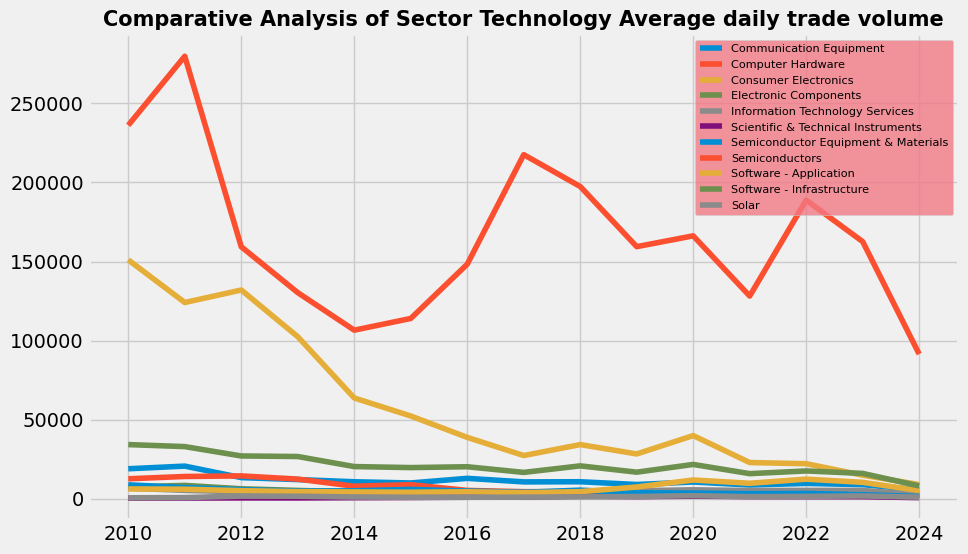

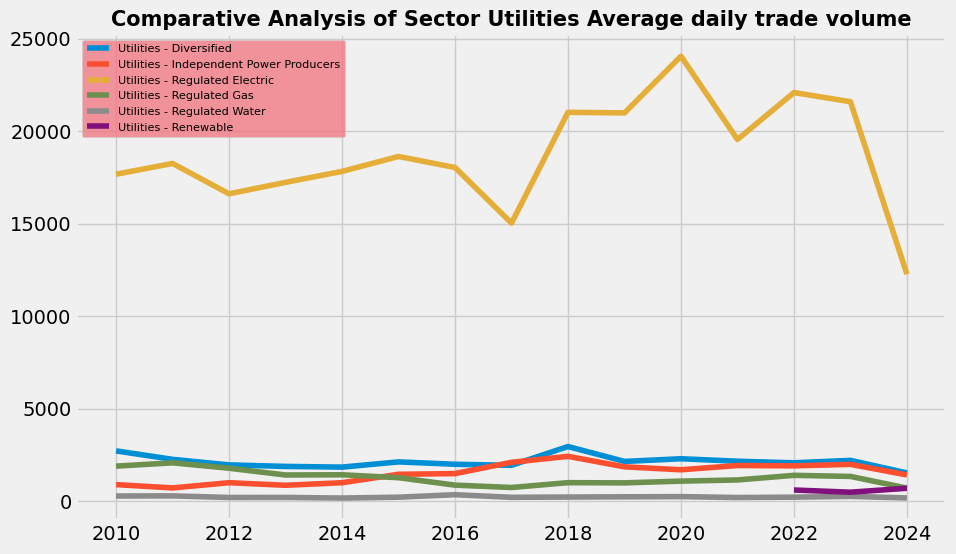

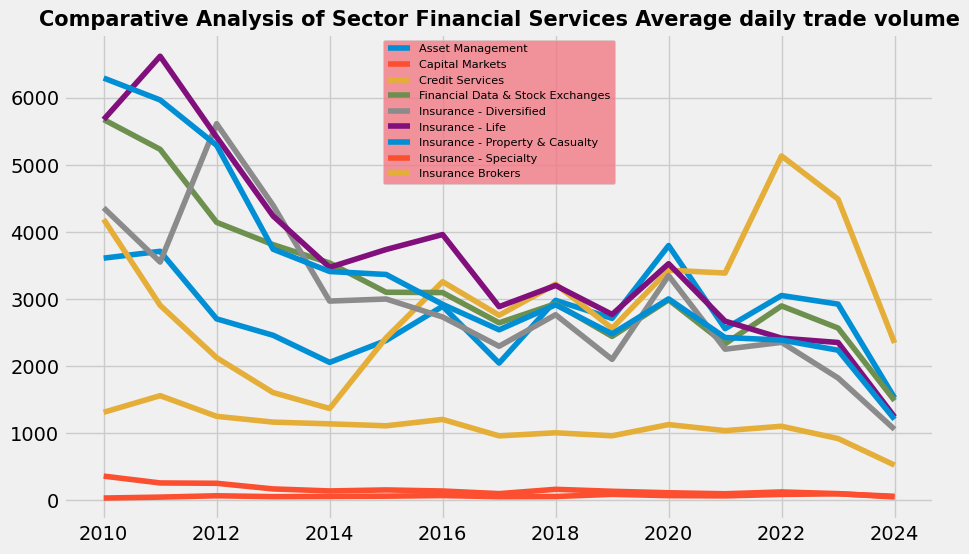

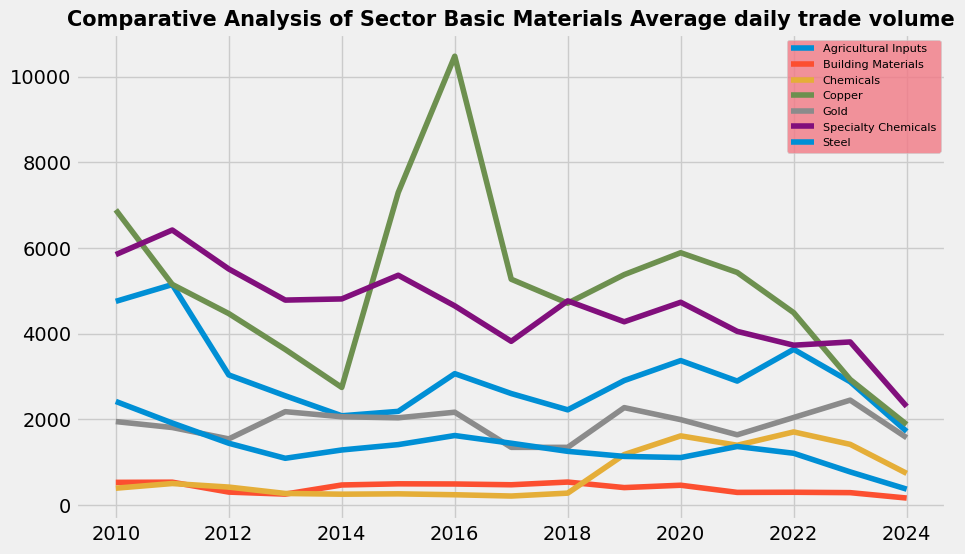

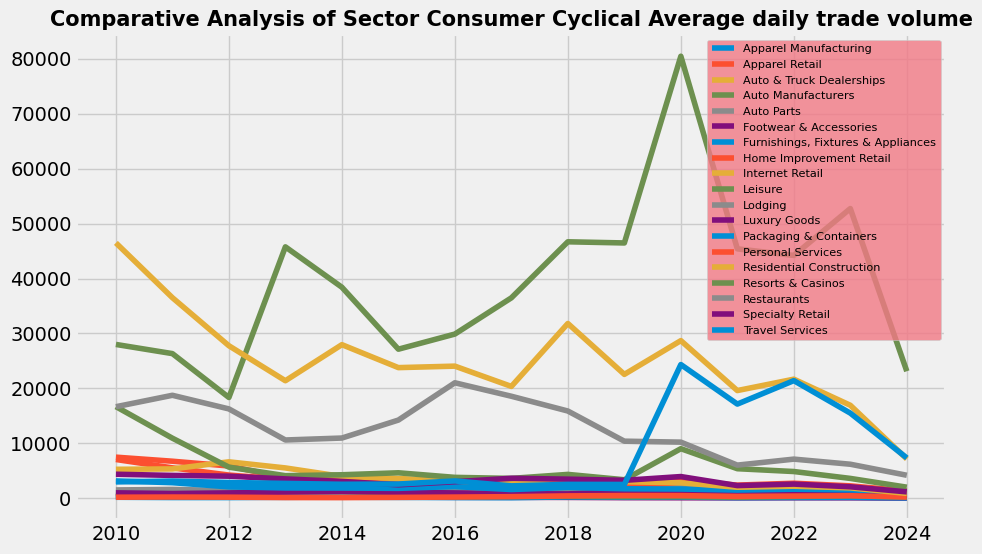

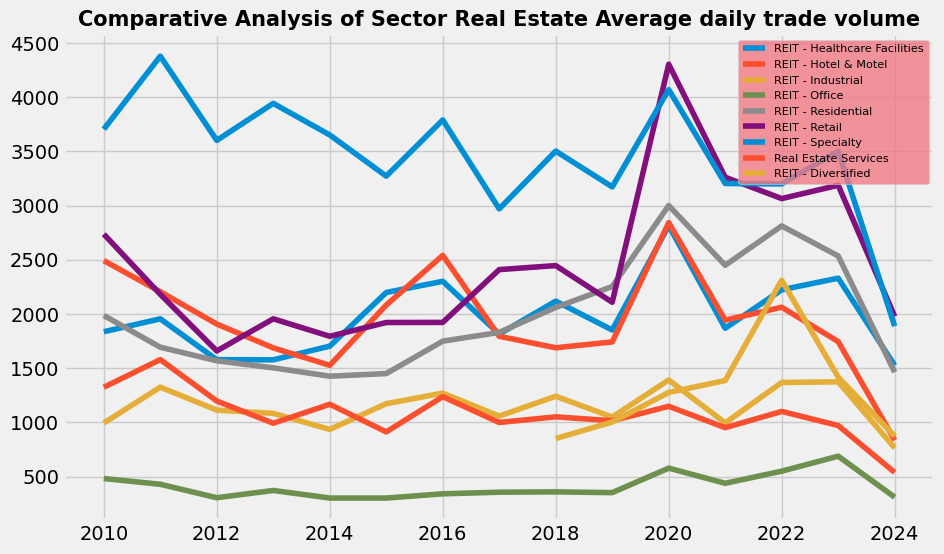

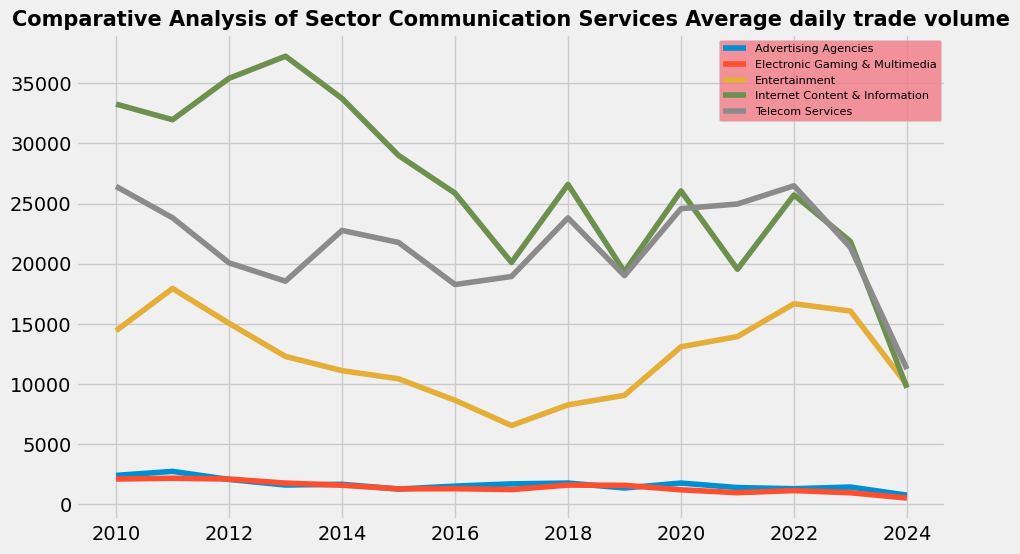

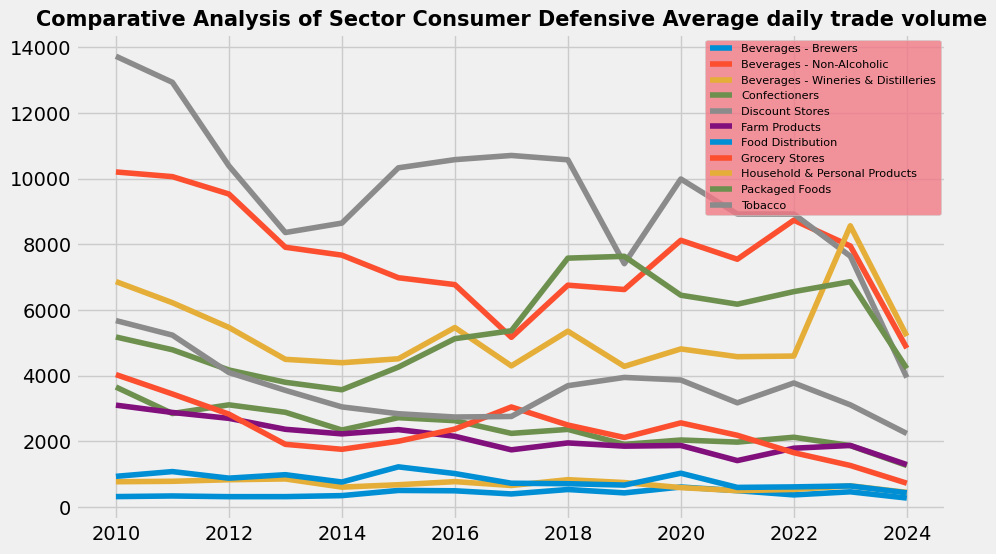

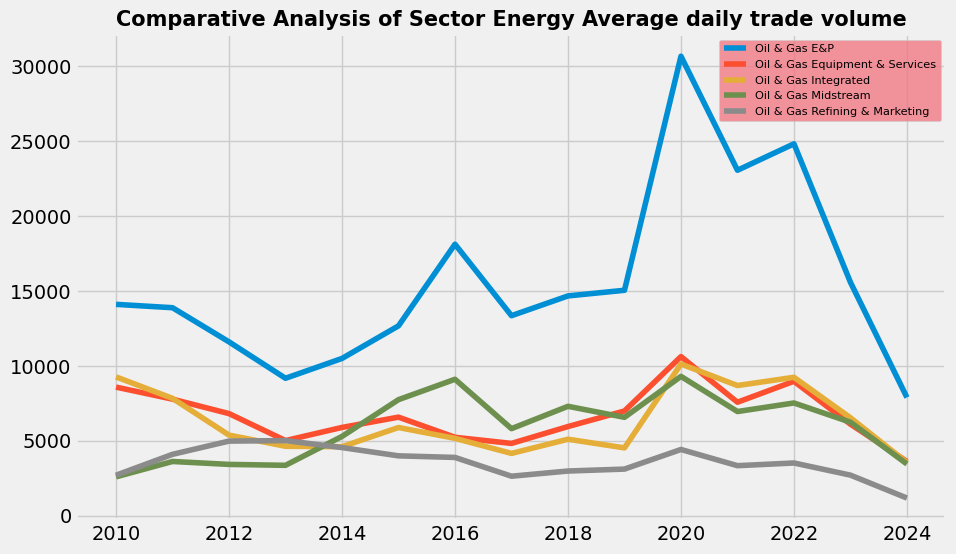

In [35]:
stocks_meta_data=pd.merge(sp_500_stocks,sp_500_companies, how='left', on=['Symbol'])
color={'Electronic Gaming & Multimedia':'#f2f23f','Internet Content & Information':'#92f005','Telecom Services':'#f55c0a','Entertainment':'#0af5ba','Advertising Agencies':'#0a93f5'}
for sec in stocks_meta_data[~stocks_meta_data['Sector'].isnull()]['Sector'].unique():
    fig1, ax1=plt.subplots(figsize=(10,6))
    indus_data=stocks_meta_data[stocks_meta_data['Sector']==sec].groupby(['year', 'Industry'])['Volume'].sum().apply(lambda x:x/1000000).reset_index().round()
    for indus in indus_data['Industry'].unique():
        ax1.plot(indus_data[indus_data['Industry']==indus]['year'], indus_data[indus_data['Industry']==indus]['Volume'], label=indus)

    ax1.set_title(f"Comparative Analysis of Sector {sec} Average daily trade volume", weight='bold', fontsize=15)
    ax1.legend(facecolor='#f27985', fontsize="xx-small")
    plt.show()

In [36]:
stocks_meta_data[stocks_meta_data['Sector']=='Communication Services']['Industry'].unique()

array(['Internet Content & Information', 'Telecom Services',
       'Electronic Gaming & Multimedia', 'Entertainment',
       'Advertising Agencies'], dtype=object)

Growth in stocks over period of 5 years (Stocks considered are: Amazon, Facebook, Home Depot, Apple, Chipotle Mexican Grill, Dollar Tree, ULTA Beauty

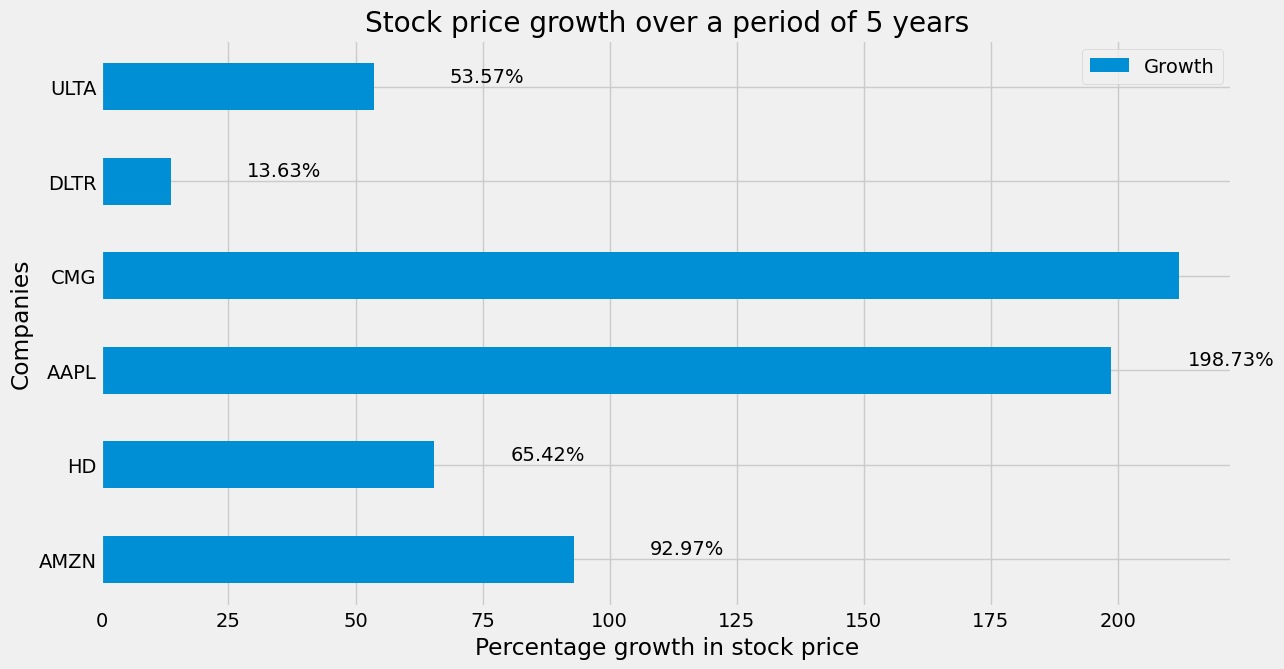

In [37]:
stocks_to_study={"Amazon.com, Inc.":"AMZN","Home Depot, Inc. (The)": "HD", "Apple Inc.":"AAPL","Chipotle Mexican Grill, Inc.":'CMG',"Dollar Tree, Inc.":"DLTR","Ulta Beauty, Inc.":"ULTA"}
sp_stocks_5yrs=sp_500_stocks[sp_500_stocks['year']>year-5]
stocks_growth=[]
for keys in stocks_to_study:
    stock=sp_stocks_5yrs[sp_stocks_5yrs['Symbol']==stocks_to_study[keys]]
    start_close=stock[stock['Date']==stock['Date'].min()]['Close'].values.item()
    end_close=stock[stock['Date']==stock['Date'].max()]['Close'].values.item()
    growth=round((end_close-start_close)/start_close*100,2)
    stocks_growth.append({'Symbol':stocks_to_study[keys],
                         'Growth':growth})
df=pd.DataFrame(stocks_growth)
ax=df.plot.barh(x="Symbol", figsize=(13,7))
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Companies')
ax.set_title("Stock price growth over a period of 5 years")
plt.show()


In [38]:
data = sp_500_companies.copy()
display(data)
print(data.columns.tolist())


,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight,Ebita
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,224.31,3439.59,1.296290e+11,-0.043,Cupertino,CA,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",6.69,129.63
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,437.11,3248.74,1.259820e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,6.32,125.98
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,117.93,2900.88,4.927500e+10,2.621,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,5.64,49.27
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,179.39,2205.24,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,4.29,109.72
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,177.66,2205.24,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,4.29,109.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,32.62,7.43,1.857000e+09,0.063,Auburn Hills,MI,United States,39900.0,"BorgWarner Inc., together with its subsidiarie...",0.01,1.86
499,NMS,ETSY,"Etsy, Inc.","Etsy, Inc.",Consumer Cyclical,Internet Retail,62.76,7.34,4.262970e+08,0.008,Brooklyn,NY,United States,2420.0,"Etsy, Inc., together with its subsidiaries, op...",0.01,0.43
500,NYQ,IVZ,Invesco Ltd,Invesco Ltd.,Financial Services,Asset Management,16.21,7.29,9.988000e+08,0.040,Atlanta,GA,United States,8527.0,Invesco Ltd. is a publicly owned investment ma...,0.01,1.00
501,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,57.82,7.22,6.624000e+08,-0.317,Philadelphia,PA,United States,6200.0,"FMC Corporation, an agricultural sciences comp...",0.01,0.66


['Exchange', 'Symbol', 'Shortname', 'Longname', 'Sector', 'Industry', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight', 'Ebita']


In [43]:
data1=data.sort_values('Weight',ascending=False)
print(len(data))

448


In [44]:
fig = px.bar(data1[:30], x='Symbol', y='Weight',title="SP500 Industry Weight Ranking")
fig.show()


In [47]:
data2=data[['Sector','Weight']].groupby('Sector',as_index=False).sum().sort_values('Weight',ascending=False)
display(data2)

,Sector,Weight
9,Technology,29.58
1,Communication Services,13.64
6,Healthcare,10.00
2,Consumer Cyclical,9.68
7,Industrials,6.59
3,Consumer Defensive,6.01
5,Financial Services,5.45
4,Energy,3.36
10,Utilities,2.20
8,Real Estate,2.06


In [48]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [49]:
fig = px.bar(data2, x='Sector', y='Weight',title="SP500 Industry Weight Ranking by Sector")
fig.show()

In [50]:
sectors=data2['Sector'].tolist()
print(sectors)

['Technology', 'Communication Services', 'Healthcare', 'Consumer Cyclical', 'Industrials', 'Consumer Defensive', 'Financial Services', 'Energy', 'Utilities', 'Real Estate', 'Basic Materials']


In [51]:
for item in sectors:
    fig = px.bar(data1[data1['Sector']==item][:30], x='Symbol', y='Weight',title="SP500 Industry Weight Ranking in "+item+' Sector')
    fig.show()